In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mwgcs import get_spherical_representation, get_cartesian_representation, Einasto, Profile, NFW

from scipy.special import gammainc, gamma

Gravitree path added to sys.path.


In [2]:
class EinastoGPT(Profile):
    def __init__(self, alpha, scaleRadius, logScaleDensity):
        """
        Sets initial fitting parameters.

        Parameters
        ----------
        Rs : float (optional, default=1)
            Scale radius of the Einasto profile in kpc
        
        logScaleDensity : float (optional, default=0)
            Log of the density at Rs in Msun/kpc^3
        
        alpha : float (optional, default=0.18)
            Shape parameter of the Einasto profile
        """

        self.alpha = alpha
        self.Rs = scaleRadius
        self.logScaleDensity = logScaleDensity

    def A(self):
        """
        Assuming an Einasto profile, the radius at which the density curve is maximal is A times the scale radius Rs.

        Returns
        -------
        float
            A parameter for the Einasto profile
        """
        return 1.715 * (self.alpha**(-.00183)) * (self.alpha + 0.0817)**(-.179488)

    def density(self, r):
        return (10**self.logScaleDensity) * np.exp(-2/self.alpha * ((r/self.Rs)**self.alpha - 1))

    def mass(self, r):
        """
        Enclosed mass of the profile at radius r
        """
        integ = lambda r: self.density(r) * 4 * np.pi * r**2
        menc = quad(integ, 0, r)[0]
        return menc

    def potential(self, r, G=4.302e-3):
        """
        Calculate the gravitational potential for an Einasto profile.
        
        Parameters:
        - r: Radius at which to evaluate the potential (kpc).
        - rho_0: Central density (M_sun/kpc^3).
        - r_s: Scale radius (kpc).
        - alpha: Shape parameter.
        - G: Gravitational constant (kpc/M_sun (km/s)^2), default is 4.302e-3.
        
        Returns:
        - Phi: Gravitational potential at radius r (km^2/s^2).
        """

        rho_0, r_s, alpha = 10**self.logScaleDensity, self.Rs, self.alpha
        n = 1.0 / alpha
        d_n = 3.0 * n - 1.0 / 3.0 + 0.0079 / n
        
        # Compute the mass enclosed within radius r
        def mass_enclosed(r):
            return 4 * np.pi * rho_0 * r_s**3 * np.exp(d_n) * n * gammainc(3*n, (r / r_s)**(1/alpha))
    
        # Potential at radius r
        M_r = mass_enclosed(r)
        Phi = -G * M_r / r
        
        return Phi

    def hessian(self, r):

        x, y, z = r, 0., 0.
        r = x
        rho_0, r_s, alpha = 10**self.logScaleDensity, self.Rs, self.alpha
    
        # Calculate the potential and its first and second derivatives with respect to r
        Phi_r = einasto_potential(r, rho_0, r_s, alpha, G)
        
        # Compute the derivatives of r with respect to x, y, z
        dr_dx = x / r
        dr_dy = y / r
        dr_dz = z / r
        
        # First partial derivatives of Phi with respect to x, y, z
        dPhi_dx = dr_dx * Phi_r
        dPhi_dy = dr_dy * Phi_r
        dPhi_dz = dr_dz * Phi_r
        
        # Second partial derivatives (Hessian elements)
        d2Phi_dx2 = (1/r) * (Phi_r * (1 - dr_dx**2) - dPhi_dx)
        d2Phi_dy2 = (1/r) * (Phi_r * (1 - dr_dy**2) - dPhi_dy)
        d2Phi_dz2 = (1/r) * (Phi_r * (1 - dr_dz**2) - dPhi_dz)
        
        d2Phi_dxdy = (1/r) * (-dr_dx * dr_dy * Phi_r)
        d2Phi_dxdz = (1/r) * (-dr_dx * dr_dz * Phi_r)
        d2Phi_dydz = (1/r) * (-dr_dy * dr_dz * Phi_r)
        
        # Hessian matrix
        Hessian = np.array([[d2Phi_dx2, d2Phi_dxdy, d2Phi_dxdz],
                            [d2Phi_dxdy, d2Phi_dy2, d2Phi_dydz],
                            [d2Phi_dxdz, d2Phi_dydz, d2Phi_dz2]])
        
        return Hessian

def hessian(self, r):
    
    x, y, z = r, 0., 0.
    r = x
    rho_0, r_s, alpha = 10**self.logScaleDensity, self.Rs, self.alpha

    # Calculate the potential and its first and second derivatives with respect to r
    q = np.array([r, 0, 0])
    Phi_r = self.potential(q)
    
    # Compute the derivatives of r with respect to x, y, z
    dr_dx = x / r
    dr_dy = y / r
    dr_dz = z / r
    
    # First partial derivatives of Phi with respect to x, y, z
    dPhi_dx = dr_dx * Phi_r
    dPhi_dy = dr_dy * Phi_r
    dPhi_dz = dr_dz * Phi_r
    
    # Second partial derivatives (Hessian elements)
    d2Phi_dx2 = (1/r) * (Phi_r * (1 - dr_dx**2) - dPhi_dx)
    d2Phi_dy2 = (1/r) * (Phi_r * (1 - dr_dy**2) - dPhi_dy)
    d2Phi_dz2 = (1/r) * (Phi_r * (1 - dr_dz**2) - dPhi_dz)
    
    d2Phi_dxdy = (1/r) * (-dr_dx * dr_dy * Phi_r)
    d2Phi_dxdz = (1/r) * (-dr_dx * dr_dz * Phi_r)
    d2Phi_dydz = (1/r) * (-dr_dy * dr_dz * Phi_r)
    
    # Hessian matrix
    Hessian = np.array([[d2Phi_dx2, d2Phi_dxdy, d2Phi_dxdz],
                        [d2Phi_dxdy, d2Phi_dy2, d2Phi_dydz],
                        [d2Phi_dxdz, d2Phi_dydz, d2Phi_dz2]])
    
    return Hessian

In [3]:
rho_0 = 10**(3)  # M_sun/kpc^3
r_s = 4. # kpc
alpha = 0.18

profile = Einasto(alpha, r_s, np.log10(rho_0))
gpt_profile = EinastoGPT(alpha, r_s, np.log10(rho_0))

In [4]:
r = np.logspace(-1, 2, 1000)

pot = [profile.potential(np.array([r_i, 0., 0.])) for r_i in r]
# gpt_pot = gpt_profile.potential(r)

rho = [profile.density(r_i) for r_i in r]
gpt_rho = gpt_profile.density(r)

hess = [profile.hessian(r_i)[0, 0] for r_i in r]
gpt_hess = [hessian(profile, r_i)[0, 0] for r_i in r]

In [5]:
from gala.potential import NFWPotential
from gala.units import galactic

nfw_gala = NFWPotential(1e12, 1., units=galactic)

nfw_hess = [nfw_gala.hessian([r_i, 0., 0.,])[0,0] for r_i in r]
nfw_pot = [nfw_gala([r_i, 0., 0.]) for r_i in r]
nfw_rho = [nfw_gala.density([r_i, 0., 0.]) for r_i in r]

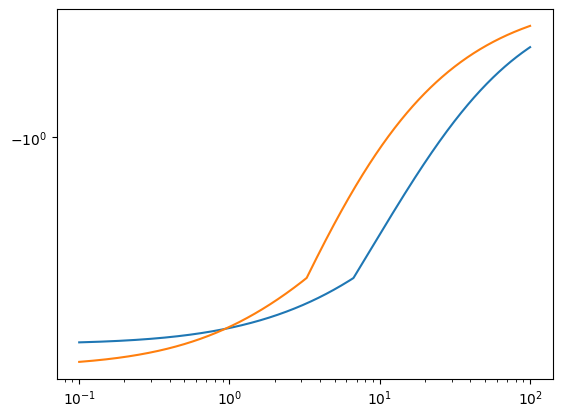

In [6]:
fig, ax = plt.subplots()
ax.plot(r, pot)
ax.plot(r, nfw_pot)
ax.set_yscale('symlog')
ax.set_xscale('log')
plt.show()

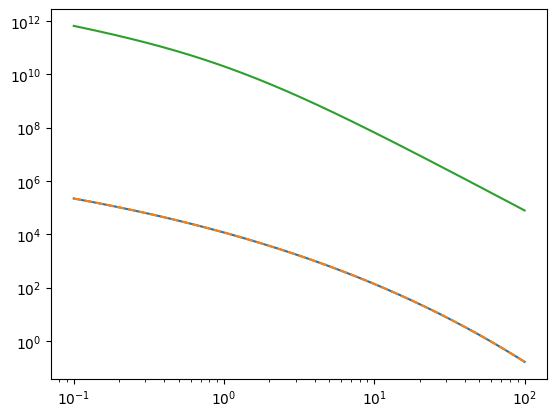

In [7]:
fig, ax = plt.subplots()
ax.loglog(r, rho)
ax.loglog(r, gpt_rho, ls='--')
ax.loglog(r, nfw_rho)
plt.show()

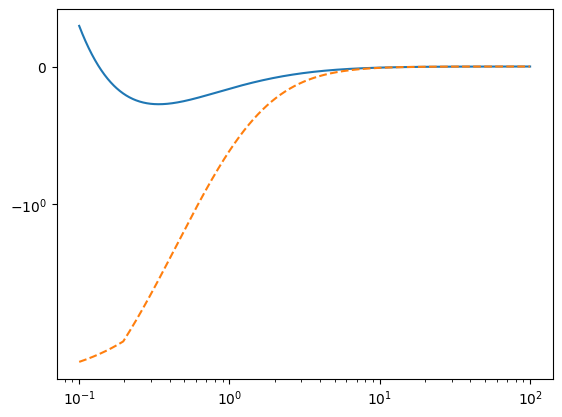

In [8]:
fig, ax = plt.subplots()
ax.plot(r, hess)
ax.plot(r, nfw_hess, ls='--')
ax.set_yscale('symlog')
ax.set_xscale('log')
plt.show()